In [26]:
using DifferentialEquations
using Plots

In [27]:
b_val = BigFloat(3)
lambda_val = BigFloat(2.0)
g_val = BigFloat(0.1)
alpha_0 = [Complex(-sqrt(lambda_val - 1) / g_val, 0.0), Complex(-sqrt(lambda_val - 1) / g_val, 0.0)]
alpha_f = [Complex(sqrt(lambda_val - 1) / g_val, 0.0), Complex(sqrt(lambda_val - 1) / g_val, 0.0)]
t_span = (0.0, 2000.0)

(0.0, 2000.0)

In [28]:
function sol2_time()
    g_val_big = BigFloat(g_val)
    lambda_val_big = BigFloat(lambda_val)
    b_val_big = BigFloat(b_val)
    
    Vs = -1/g_val_big^2 * log(lambda_val_big^2)
    Va = -2*(lambda_val_big-1)/g_val_big^2 + 4*b_val_big/lambda_val_big*sqrt(lambda_val_big-1)/g_val_big
    Vb = -2*(lambda_val_big-1)/g_val_big^2 - 4*b_val_big/lambda_val_big*sqrt(lambda_val_big-1)/g_val_big
    
    println("Va = $Va, Vb = $Vb, Vs = $Vs")
    println(8*b_val_big^2/lambda_val_big^2*(lambda_val_big/(4*lambda_val_big-4) + 1/(8*lambda_val_big-8)))
    term1 = BigFloat(pi)/lambda_val_big * sqrt((lambda_val_big+1)/((lambda_val_big-1)^2*lambda_val_big))
    term2 = exp(Vs + 8*b_val_big^2/lambda_val_big^2*(lambda_val_big/(4*lambda_val_big-4) + 1/(8*lambda_val_big-8)))
    term3 = (exp(-Va) + exp(-Vb)) / (exp(Va-Vb) + 1)
    
    println("term1 = $term1, term2 = $term2, term3 = $term3")
    
    return term1 * term2 * term3
end

sol2_time (generic function with 1 method)

In [29]:
using PolynomialRoots
function parametrize(alpha, beta)
    u = asin(g_val*alpha/sqrt(lambda_val)) + asin(g_val*beta/sqrt(lambda_val))
    v = asin(g_val*alpha/sqrt(lambda_val)) - asin(g_val*beta/sqrt(lambda_val))
    return [u, v]
end

function sol1_time()
    function V(u,v)
        term1 = lambda_val*(cos(u)-cos(v)) - 2*log(cos(u)+cos(v))
        term2 = 2*g_val*b_val/sqrt(lambda_val)*log(cos(u)+cos(v))
        term3 = -2*g_val*b_val/sqrt(lambda_val)*log(2+2*sin((u+v)/2)+2*sin((u-v)/2)+cos(v)-cos(u))
        return term1 + term2 + term3
    end
    function Vuu(alpha)
        return (lambda_val-g_val^2*b_val*alpha)/(lambda_val-g_val^2*alpha^2)-lambda_val+2*g_val^2*alpha^2
    end
    function Vvv(alpha)
        return (lambda_val-g_val^2*b_val*alpha)/(lambda_val-g_val^2*alpha^2)+lambda_val
    end
    alpha_roots = roots([-b_val, -(lambda_val-1), 0, g_val^2])
    alpha_roots = sort(map(x->real(x), alpha_roots))
    u_roots = map(x->parametrize(x, x)[1], alpha_roots)
    Vs = V(u_roots[2],0)
    Va = V(u_roots[1],0)
    Vb = V(u_roots[3],0)

    println("Va = $Va, Vb = $Vb, Vs = $Vs")
    # put space between prints:
    println(alpha_roots[1])
    println("$(Vuu(alpha_roots[1])), $(Vvv(alpha_roots[1])), $(Vuu(alpha_roots[3])), $(Vvv(alpha_roots[3])), $(Vuu(alpha_roots[2])), $(Vvv(alpha_roots[2]))")

    term1 = 2*BigFloat(pi)*exp((Vs-Va)/g_val^2)/sqrt(Vuu(alpha_roots[1])*Vvv(alpha_roots[1]))
    term2 = 2*BigFloat(pi)*exp((Vs-Vb)/g_val^2)/sqrt(Vuu(alpha_roots[3])*Vvv(alpha_roots[3]))
    term3 = sqrt(Vvv(alpha_roots[2]) / (-Vuu(alpha_roots[2])))
    term4 = exp((Va-Vb)/g_val^2) 
    term5 = sqrt(Vuu(alpha_roots[1])*Vvv(alpha_roots[1])/Vuu(alpha_roots[3])/Vvv(alpha_roots[3]))

    return (term1+term2)*term3/(term4*term5+1)
end

sol1_time (generic function with 1 method)

In [30]:
println(sol1_time())

Va = -1.35116582808233112247993703324011228163461640159689997239837587508496712653974, Vb = -2.835470434182480121118960975400096649906952090837851686932677714012139909780104, Vs = -1.290345550218247392038026975125249802835981152335895077943031865462171551457092
-7.86482541161627111121996805427475486724975765911539410937001690816050324197393
0.8556643626561516553968045600304184480645491607268293149086068970412529065862388, 3.618554787552050551798934853343472816021516386908943104969535632347084302195407, 2.799702309744217877198038270436388319414892752337273511550201804862270313866687, 4.266567436581405959066012756812129439804964250779091170516733934954090104622287, -0.6553666724003695325948428304668067674794419130641028264588087019035232204528656, 3.114877775866543489135052389844397744173519362311965724513730432698825593182375
3409.023579455036888157208401115281489824836067304110874632428946622408037158528


In [31]:
function drift!(dalpha, alpha, p, t)
    dalpha[1] = b_val - alpha[1] + alpha[2] * (lambda_val - g_val^2 * alpha[1]^2)
    dalpha[2] = b_val - alpha[2] + alpha[1] * (lambda_val - g_val^2 * alpha[2]^2)
end

function noise!(dalpha, alpha, p, t)
    dalpha[1, 1] = sqrt(lambda_val - g_val^2 * alpha[1]^2)
    dalpha[2, 2] = sqrt(lambda_val - g_val^2 * alpha[2]^2)
    dalpha[1, 2] = 0.0
    dalpha[2, 1] = 0.0
end

W = RealWienerProcess(0.0, zeros(2), zeros(2))
problem = SDEProblem(drift!, noise!, alpha_0, t_span, noise_rate_prototype=complex(zeros(2, 2)), noise=W)

SDEProblem with uType Vector{Complex{BigFloat}} and tType Float64. In-place: true
timespan: (0.0, 2000.0)
u0: 2-element Vector{Complex{BigFloat}}:
 -9.999999999999999444888487687421760603063276150361782076232622353718522343744992 + 0.0im
 -9.999999999999999444888487687421760603063276150361782076232622353718522343744992 + 0.0im

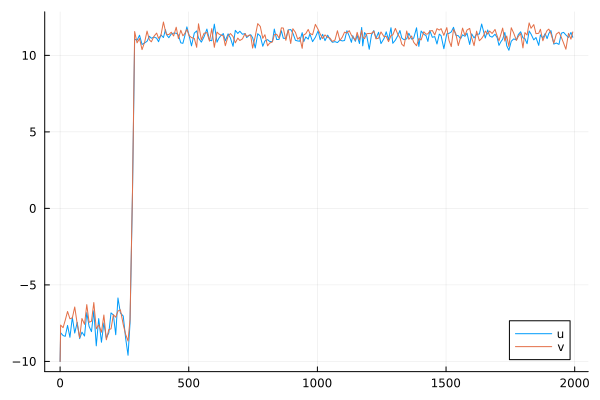

In [39]:
sol = solve(problem)
uvs = map(x->[real(x[1]), real(x[2])], sol.u)
mat = hcat(uvs...)
plot(sol.t[1:100:end], mat[1,1:100:end], label="u")
plot!(sol.t[1:100:end], mat[2,1:100:end], label="v")